In [1]:
import magic
import subprocess
try:
    import ipfsapi
except ModuleNotFoundError:
    import ipfsApi as ipfsapi
import re
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from tempfile import NamedTemporaryFile
from textblob import TextBlob
from typing import List, Optional

api = ipfsapi.connect('127.0.0.1', 5001)

class IPFSHashType(Enum):
    DATA = 0
    DIR = 1
    ERR = 2

class WikiType(Enum):
    HTMLPAGE = 0
    CRAWLED = 1
    NONE = 2

class Source(Enum):
    DHT = 0
    WEB = 1


In [12]:
wiki_hashes = set()

with open("ls_results.txt", "r") as f:
    for wiki_hash in f.read().split():
        wiki_hashes.add(wiki_hash)

FileNotFoundError: [Errno 2] No such file or directory: 'ls_results.txt'

In [7]:
done_hashes = {}

In [13]:
class FileHash:
    ipfs_hash: str
    root: bool = False
    hash_type: IPFSHashType = IPFSHashType.DATA
    refs = []
    source: Source
    file_type: str = ''
    wiki: WikiType = WikiType.NONE
    language_code: Optional[str] = None
    
    def __init__(self, ipfs_hash: str, source: Source, root: bool = False):
        self.ipfs_hash = ipfs_hash
        self.root = root
        self.source = source
        
        if ipfs_hash in done_hashes:
            return

        done_hashes[ipfs_hash] = None
        self.readline()
        done_hashes[ipfs_hash] = self

    def __str__(self) -> str:
        return '{} {} {}'.format(self.ipfs_hash, self.hash_type, self.file_type)

    def readline(self) -> None:
        try:
            line = api.cat(self.ipfs_hash)
            self.set_file_type(line)
            self.set_wikipedia(line)
        except ipfsapi.exceptions.Error as e:
            self.hash_type = IPFSHashType.DIR
            self.add_refs()
    
    def add_refs(self):
        res = api.ls(self.ipfs_hash)['Objects'][0]['Links']
        res = map(lambda link: link['Hash'], res)
        for h in res:
            self.refs.append(FileHash(h, self.source, root = False))
        
    def set_file_type(self, line: bytes):
        if self.hash_type != IPFSHashType.DATA:
            raise Exception('cannot get file type of non-file')
        f = NamedTemporaryFile()
        f.write(line)
        f.seek(0)
        self.file_type = magic.from_file(f.name);

    def set_wikipedia(self, line: bytes):
        if b'mediawiki' in line:
            self.wiki = WikiType.HTMLPAGE
            regex = r'.*(<p id=.*</p>).*'
            match = re.match(regex, str(line))
            self.language_code = TextBlob(match.groups()[0]).detect_language()
        elif self.ipfs_hash in wiki_hashes:
            self.wiki = WikiType.CRAWLED
        

In [14]:
def analyze(source: Source, hashes: List[str]) -> None:
    for h in hashes:
        FileHash(h, source = source, root = True)

In [ ]:
hashes = []
with open("index_results.txt", "r") as f:
    for line in f.read().split('\n'):
        if line == '':
            continue
        if line[0] == ' ':  # only accept root hashes
            continue
        file_hash = line.split()[-1]
        hashes.append(file_hash)

analyze(Source.DHT, hashes)
for h in done_hashes:
    fh = done_hashes[h]
    print(fh)

In [18]:
web_hashes = []
with open("ipfs_web_crawl_hashes.txt", "r") as f:
    for line in f:
        web_hashes.append(line.strip())

analyze(Source.WEB, web_hashes)
for _, fh in done_hashes:
    print(fh)

KeyboardInterrupt: 

<BarContainer object of 0 artists>

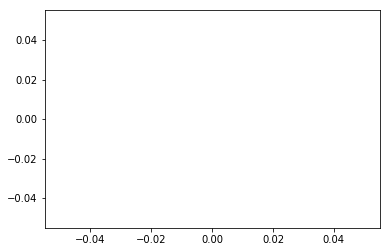

In [9]:
file_types = {}

for _, fh in done_hashes:
    if not fh.file_type in file_types:
        file_types[fh.file_type] = 0
    file_types[fh.file_type] += 1
    
file_types_x = []
file_types_y = []

for x,y in file_types:
    file_types_x.append(x)
    file_types_y.append(y)

plt.figure()
plt.bar(file_types_x, file_types_y);